In [1]:
import os
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow_addons as tfa
import tensorflow_probability as tfp
import zipfile
import time
from PIL import Image
from tqdm import tqdm

d:\Users\germa\anaconda3\envs\DL\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\Users\germa\anaconda3\envs\DL\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.3.0 and strictly below 2.6.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.6.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [4]:
from src.setupData import load_voc_dataset, _parse_features, load_coco_dataset
from src.augmentations import Ada, build_augmenter
from src.utils import visualize_boxes, visualize_outputs, plot_grid_anchors
from src.postprocessing import bbox_iou, decode_model_outputs, non_max_suppression, NMS
from src.callbacks import create_callbacks
from models.bbox_preprocess import TransformBoxes
from models.loss import lossFunction
from models.model import Mean, MyModel, make_dummy_model
from tools.read_tfRecord import read_tfrecord, get_tfrecordkeys

In [6]:
class args:
    img_size = (256, 256)
    buffer_size = 64
    batch_size = 16
    epochs = 100
    NUM_CLASSES = 100
    aug_translate = 0.2
    aug_rot = 40
    aug_scale = 0.35
    aug_kernel_size = 5
    aug_sigma = 1
    ada_initial_probability = 0.0
    lambda_box = 5
    lambda_noobj = 10 # 0.5
    lambda_class = 1
    max_output_size = 50
    max_output_size_per_class = 30
    iou_threshold = 0.5
    confidence_threshold = 0.5
    ignore_thresh = 0.5
    optimizer = 'adam'
    monitor = 'loss'

config_opt = {"learning_rate": 1e-3, "beta_1": 0.15, "beta_2": 0.99, "epsilon": 1e-8}
grid_sizes = [8, 16, 32] # [8, 16, 32], [13, 26, 52]
NORMALIZED_ANCHORS = [[(0.28, 0.22), (0.38, 0.48), (0.9, 0.78)], 
                      [(0.07, 0.15), (0.15, 0.11), (0.14, 0.29)],
                      [(0.02, 0.03), (0.04, 0.07), (0.08, 0.06)]]

yolo_anchors = tf.constant([[(116, 90), (156, 198), (373, 326)],
                            [(30, 61), (62, 45), (59, 119)], 
                            [(10, 13), (16, 30), (33, 23)]], tf.float32) / 416.

voc_train_ds_path = r"D:\DL-CV-ML Projects\Turion_Space\Object Detection (OLD)\data\voc\voc2012_train.tfrecord"
voc_val_ds_path = r"D:\DL-CV-ML Projects\Turion_Space\Object Detection (OLD)\data\voc\voc2012_val.tfrecord"
coco_train_ds_path = r"D:\DL-CV-ML Projects\Turion_Space\Object Detection\data\COCO_data_train.tfrecord"
coco_val_ds_path = r"D:\DL-CV-ML Projects\Turion_Space\Object Detection\data\COCO_data_val.tfrecord"
img_path = r'D:\DL-CV-ML Projects\Turion_Space\Updated_Turion_Space\imgs\img.png'
save_model_path = r'D:\DL-CV-ML Projects\Turion_Space\Object Detection\Object Detection\model_weights\model.h5'

augmentations = [RandomHorizontalFlip(), 
                 RandomTranslate(translate=args.aug_translate), 
                 RandomRotate(rot=args.aug_rot), 
                 RandomZoom(scale=args.aug_scale), 
                 RandomMirror(), 
                 AddNoise(), 
                 RandomGamma(), 
                 GaussianBlur(kernel_size=args.aug_kernel_size, sigma=args.aug_sigma)]

# Load Data

In [7]:
ds_train = load_coco_dataset(args, coco_val_ds_path, augment_func = None, split = 'train') ######################### USE VAL FOR NOW AS TRAIN IS LONG
# ds_train = load_voc_dataset(args, voc_train_ds_path, None, 'train')

Loading train dataset from D:\DL-CV-ML Projects\Turion_Space\Object Detection\data\COCO_data_val.tfrecord...


In [8]:
tmvm = iter(ds_train)

In [9]:
kvsdk = next(tmvm)

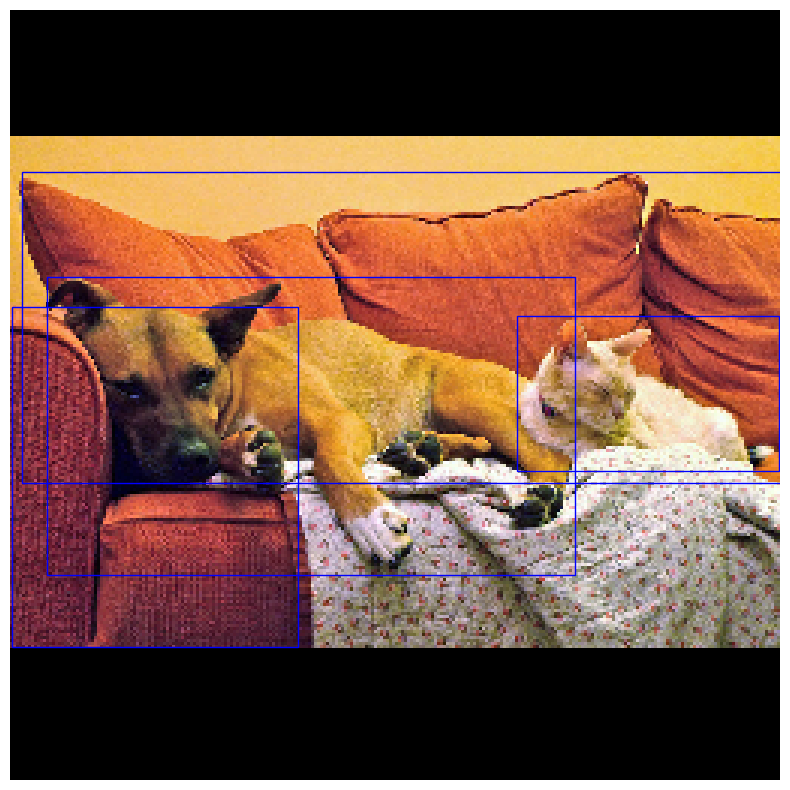

In [10]:
i = 0
img_to_test = kvsdk[0][i]
its_bboxes = kvsdk[1][i]
img_y = img_to_test.shape[0]
img_x = img_to_test.shape[1]
scale = tf.constant([img_y, img_x, img_y, img_x], dtype=tf.float32)
visualize_boxes(img_to_test, its_bboxes[..., :-1]*scale, figsize=(10, 10), linewidth=1, color=[0, 0, 1])

In [11]:
setup_bboxes = TransformBoxes(grid_sizes, yolo_anchors)

In [12]:
grid = setup_bboxes(kvsdk[1])

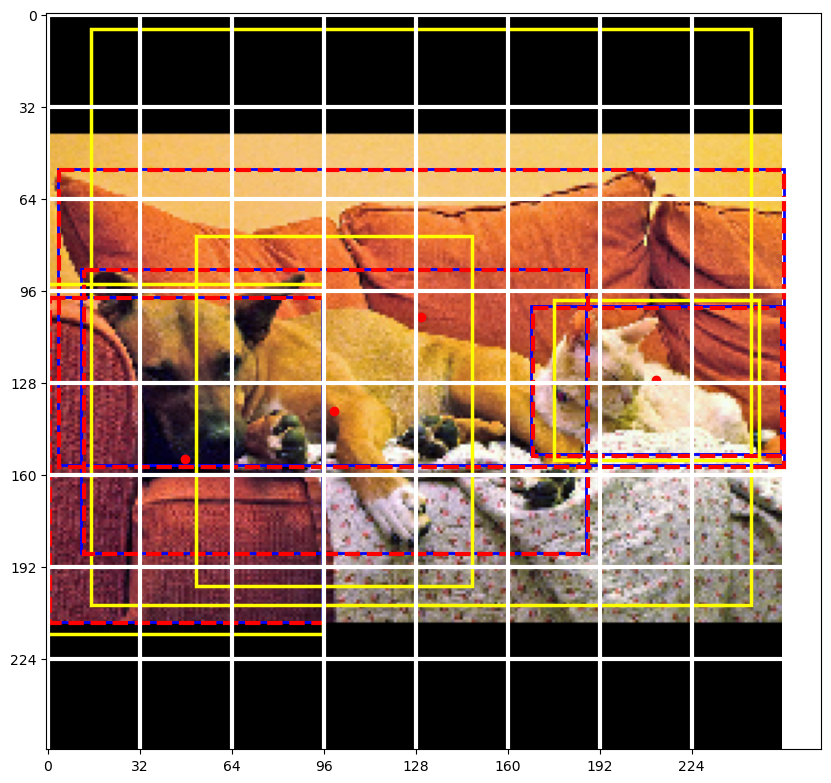

Total bboxes: 4, Total anchors: 4


In [13]:
c = 0
plot_grid_anchors(img_to_test, its_bboxes, grid[c], (10, 10), yolo_anchors[c], False, ['bbox', 'anchors', 'prediction']) # ['bbox', 'prediction', 'anchors']

# Make Sure Augmentations Work

In [19]:
augmenter = Ada(aug_functions=augmentations, img_size=args.img_size, initial_probability=0.0, switch=True)

In [21]:
augmenter.update(tf.constant(0.9))
print(augmenter.probability)
test_ada = augmenter(kvsdk, training=True)

<tf.Variable 'ada_p:0' shape=(1, 1) dtype=float32, numpy=array([[0.02840798]], dtype=float32)>


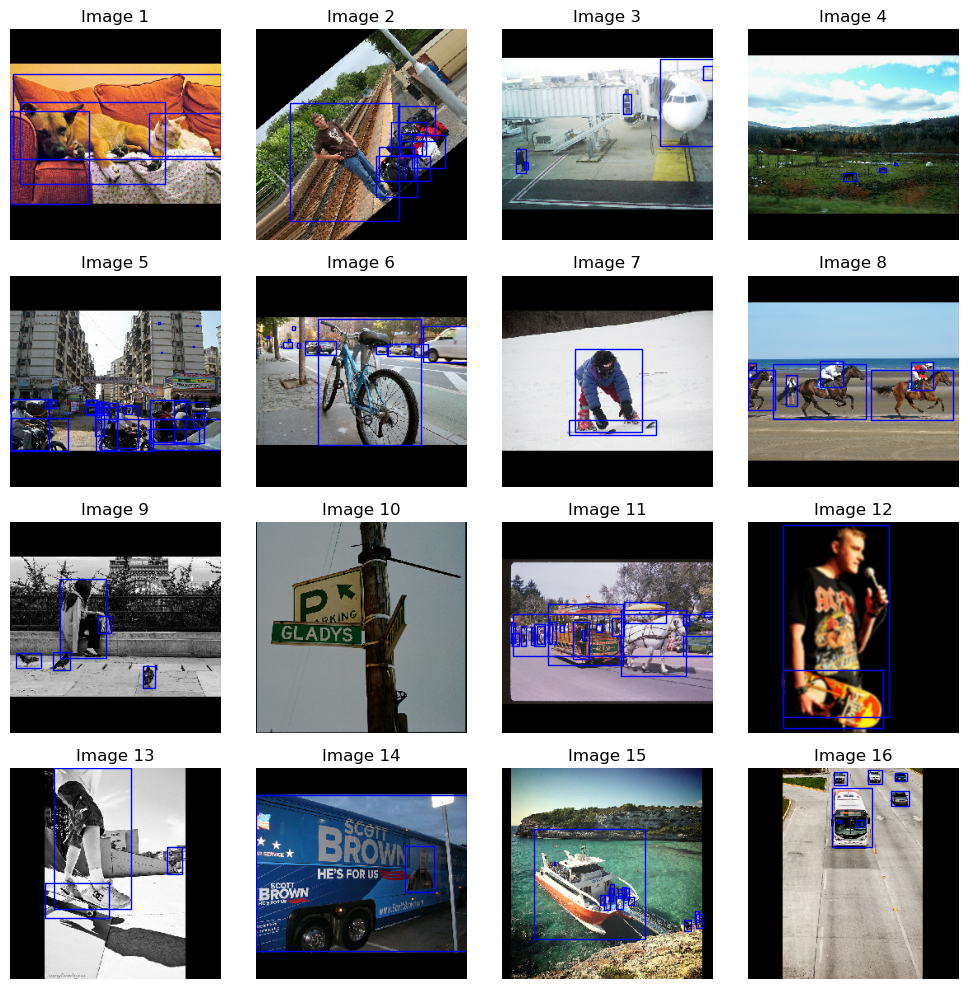

In [22]:
visualize_outputs(test_ada[0], test_ada[1][..., :-1], scale=tf.constant([256, 256, 256, 256], dtype=tf.float32), figsize=(10, 10), linewidth=1, color=[0, 0, 1])

In [23]:
grid2 = setup_bboxes(test_ada[1])

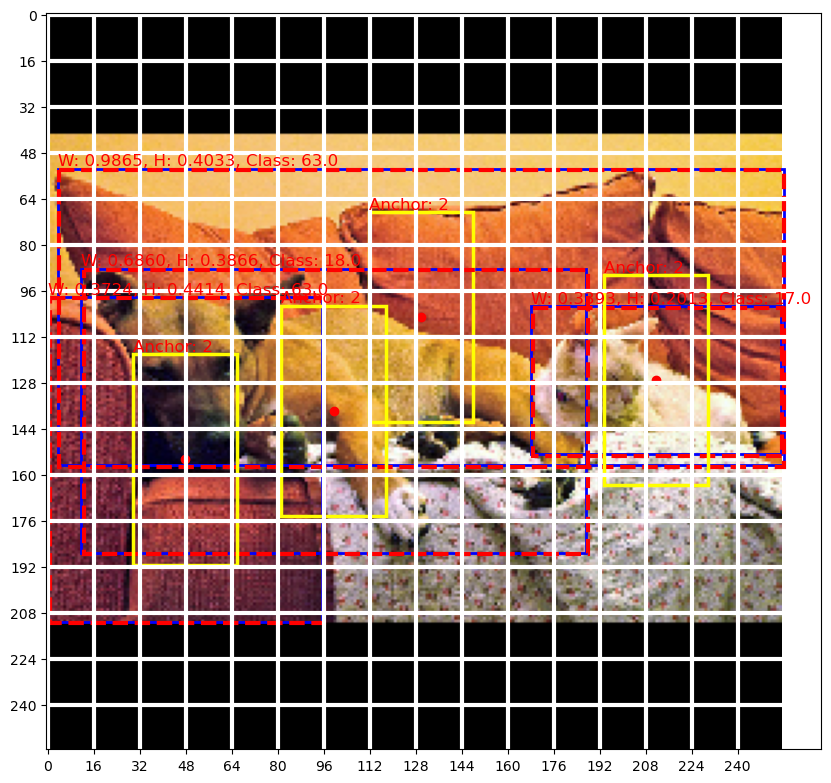

Total bboxes: 4, Total anchors: 4


In [25]:
c = 1
indx = 0
plot_grid_anchors(test_ada[0][indx], test_ada[1][indx], grid2[c][indx], (10, 10), yolo_anchors[c], True, ['bbox', 'anchors', 'prediction']) # ['bbox', 'prediction', 'anchors']

# Train

In [14]:
def setupModel(args, grid_sizes, anchors, augmentations, save_model_path, config_opt):

    augment_func = Ada(aug_functions=augmentations, img_size=args.img_size, initial_probability=args.ada_initial_probability, switch=True)
    test_mymodel = MyModel(img_size=args.img_size, augment_func=augment_func, grid_sizes=grid_sizes, anchors=anchors, args=args)

    loss1 = lossFunction(anchors[0], args.ignore_thresh, args.lambda_box, args.lambda_noobj, args.lambda_class)
    loss2 = lossFunction(anchors[1], args.ignore_thresh, args.lambda_box, args.lambda_noobj, args.lambda_class)
    loss3 = lossFunction(anchors[2], args.ignore_thresh, args.lambda_box, args.lambda_noobj, args.lambda_class)
    loss_list = [loss1, loss2, loss3]

    callback_list = create_callbacks(save_model_path, args, test_mymodel, anchors, img_path = r'D:\DL-CV-ML Projects\Turion_Space\Updated_Turion_Space\imgs\img.png')

    if args.optimizer == 'scd':

        learning_rates = [2.5e-06, 0.000625, 0.00125, 0.0025, 0.00025, 2.5e-05]
        learning_rate_boundaries = [125, 250, 500, 240000, 360000]
        learning_rate_fn = tf.optimizers.schedules.PiecewiseConstantDecay(boundaries=learning_rate_boundaries, values=learning_rates)
        optimizer = tf.optimizers.SGD(learning_rate=learning_rate_fn, momentum=0.9)

    if args.optimizer == 'adam':
        optimizer = tf.keras.optimizers.Adam()
        optimizer = optimizer.from_config(config=config_opt)

    else:
        optimizer = tf.keras.optimizers.get(args.optimizer)
        optimizer = optimizer.from_config(config=config_opt)

    return test_mymodel, loss_list, callback_list, optimizer

In [15]:
test_mymodel, loss_list, callbacks_list, optimizer = setupModel(args, grid_sizes, yolo_anchors, augmentations, save_model_path, config_opt)

In [17]:
test_mymodel.compile(optimizer=optimizer, metrics = [Mean(name="aug_probability")], loss=loss_list)

Epoch 1/5


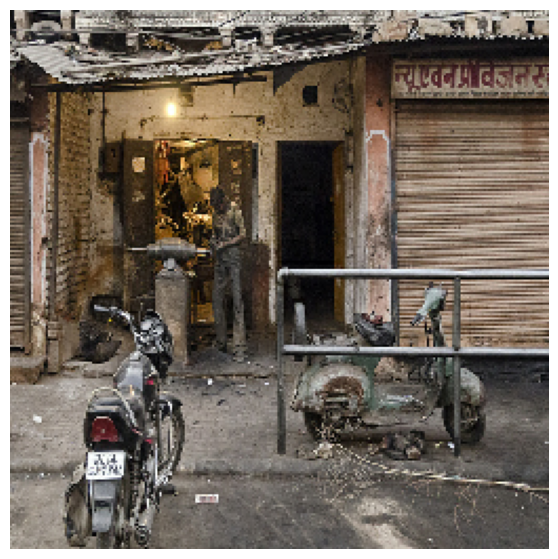

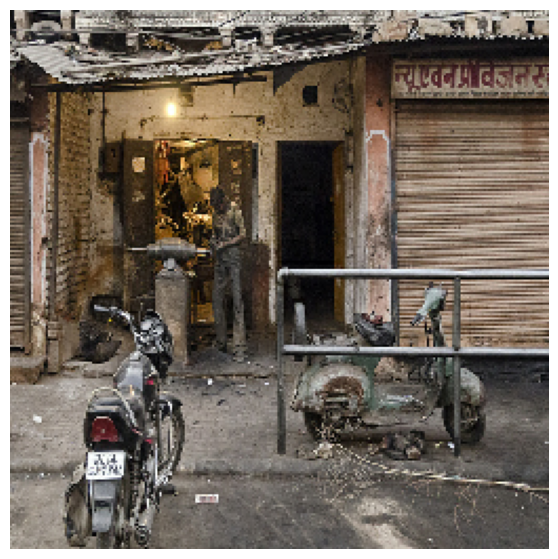

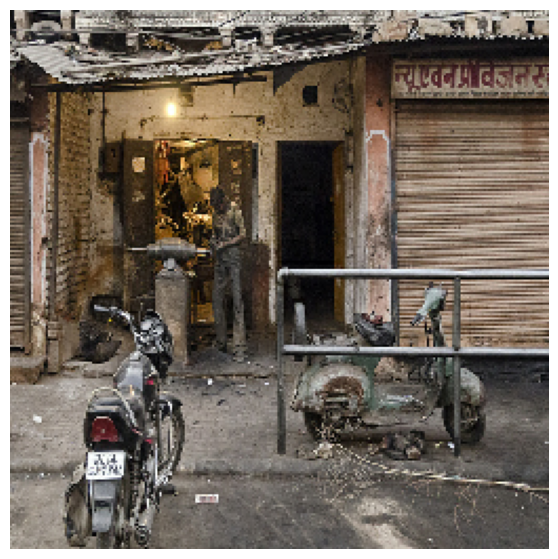

312/312 [==============================] - 92s 236ms/step - loss: 131.0382 - output_1_loss: 39.4539 - output_2_loss: 44.8216 - output_3_loss: 46.7627 - aug_probability: 0.0301 - iou_tracker: 0.1045

Epoch 1: loss improved from inf to 131.03822326660156, saving model to D:\DL-CV-ML Projects\Turion_Space\Object Detection\Object Detection\model_weights\model.h5
Epoch 2/5
312/312 [==============================] - 74s 237ms/step - loss: 118.4073 - output_1_loss: 36.1682 - output_2_loss: 42.1799 - output_3_loss: 40.0592 - aug_probability: 0.0291 - iou_tracker: 0.1014

Epoch 2: loss improved from 131.03822326660156 to 118.40727996826172, saving model to D:\DL-CV-ML Projects\Turion_Space\Object Detection\Object Detection\model_weights\model.h5
Epoch 3/5


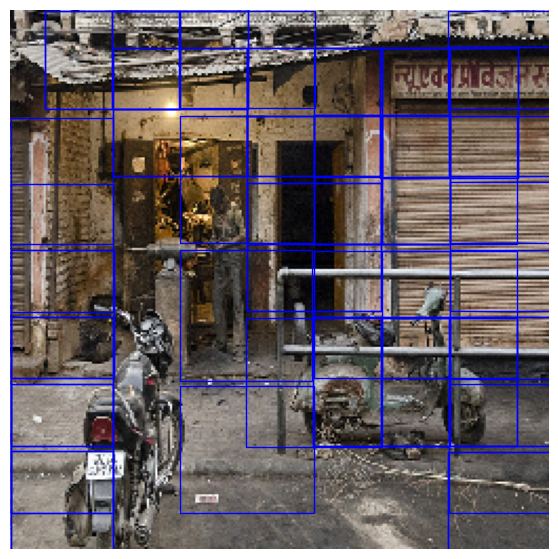

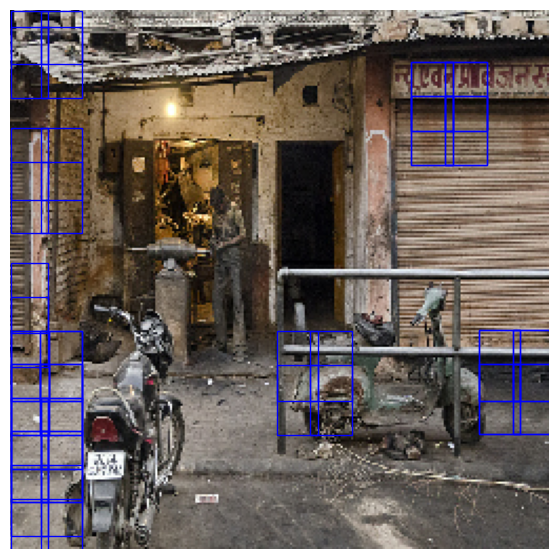

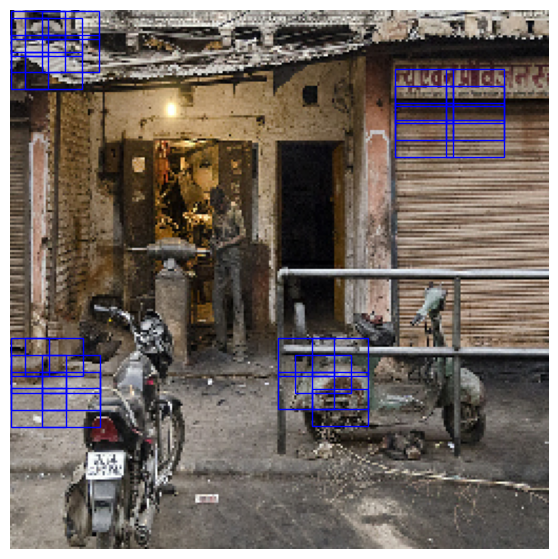

312/312 [==============================] - 78s 246ms/step - loss: 115.7104 - output_1_loss: 35.3249 - output_2_loss: 41.6315 - output_3_loss: 38.7540 - aug_probability: 0.0297 - iou_tracker: 0.1032

Epoch 3: loss improved from 118.40727996826172 to 115.71041107177734, saving model to D:\DL-CV-ML Projects\Turion_Space\Object Detection\Object Detection\model_weights\model.h5
Epoch 4/5
312/312 [==============================] - 77s 248ms/step - loss: 114.3521 - output_1_loss: 34.8550 - output_2_loss: 41.3587 - output_3_loss: 38.1385 - aug_probability: 0.0301 - iou_tracker: 0.1044

Epoch 4: loss improved from 115.71041107177734 to 114.35213470458984, saving model to D:\DL-CV-ML Projects\Turion_Space\Object Detection\Object Detection\model_weights\model.h5
Epoch 5/5
312/312 [==============================] - 75s 240ms/step - loss: 113.0199 - output_1_loss: 34.3322 - output_2_loss: 41.1179 - output_3_loss: 37.5698 - aug_probability: 0.0313 - iou_tracker: 0.1082

Epoch 5: loss improved from 1

In [18]:
test_mymodel.fit(ds_train, epochs=5, callbacks=callbacks_list)

# Extra

In [ ]:
# y_true1 = grid[0]
# y_pred1 = tf.random.uniform(tf.shape(y_true1) + (0, 0, 0, 0, 99))
# y_true2 = grid[1]
# y_pred2 = tf.random.uniform(tf.shape(y_true2) + (0, 0, 0, 0, 99))
# y_true3 = grid[2]
# y_pred3 = tf.random.uniform(tf.shape(y_true3) + (0, 0, 0, 0, 99))


# bbox_true1, conf1, obj_class1 = tf.split(y_true1, [4, 1, 1], axis=-1)
# obj_class1 = tf.squeeze(tf.one_hot(tf.cast(obj_class1, tf.int32), 100, axis=-1))
# obj_class1 = tf.math.log(obj_class1 / (1 - obj_class1))
# conf1 = tf.math.log(conf1 / (1 - conf1))
# y_pred1 = tf.concat([bbox_true1, conf1, obj_class1], axis=-1)
# small_noise1 = tf.random.normal(tf.shape(y_pred1), mean=0, stddev=.1)
# y_pred1 = y_pred1+small_noise1

# bbox_true2, conf2, obj_class2 = tf.split(y_true2, [4, 1, 1], axis=-1)
# obj_class2 = tf.squeeze(tf.one_hot(tf.cast(obj_class2, tf.int32), 100, axis=-1))
# obj_class2 = tf.math.log(obj_class2 / (1 - obj_class2))
# conf2 = tf.math.log(conf2 / (1 - conf2))
# y_pred2 = tf.concat([bbox_true2, conf2, obj_class2], axis=-1)
# small_noise2 = tf.random.normal(tf.shape(y_pred2), mean=0, stddev=.1)
# y_pred2 = y_pred2+small_noise2

# bbox_true3, conf3, obj_class3 = tf.split(y_true3, [4, 1, 1], axis=-1)
# obj_class3 = tf.squeeze(tf.one_hot(tf.cast(obj_class3, tf.int32), 100, axis=-1))
# obj_class3 = tf.math.log(obj_class3 / (1 - obj_class3))
# conf3 = tf.math.log(conf3 / (1 - conf3))
# y_pred3 = tf.concat([bbox_true3, conf3, obj_class3], axis=-1)
# small_noise3 = tf.random.normal(tf.shape(y_pred3), mean=0, stddev=.1)
# y_pred3 = y_pred3+small_noise3


# print(K.mean(loss1(y_true1, y_pred1)))
# print('--------------------------------')
# print(K.mean(loss2(y_true2, y_pred2)))
# print('--------------------------------')
# print(K.mean(loss3(y_true3, y_pred3)))


In [ ]:
    #   count_pos_values = tf.math.count_nonzero(bboxes, axis=-1, dtype=tf.float32) # Count num of nonzeros in the rows
    #   rows_to_keep = tf.clip_by_value(count_pos_values, 0, 1)[None, ...] # Any row that had a nonzero value will be kept

    #   perm_T = tf.roll(tf.range(0, tf.rank(bboxes)), -1, axis=0) # Get the permutation
    #   col_vector = tf.transpose(rows_to_keep, perm_T) # Transform the rows_to_keep into a column vector 
      
    #   mask = tf.repeat(col_vector, 4, axis=-1) # Repeat the column vector 4 times to match bboxes
    #   return mask

In [21]:
# bvdmfs =0
# for imgs in kvsdk[1]:
#     bvdmfs+=tf.math.count_nonzero(tf.math.count_nonzero(imgs, axis=-1, dtype=tf.bool))
# bvdmfs

# b = make_output(tf.random.uniform((12, 8, 8, 3, 6)), tf.random.uniform((12, 38, 3), maxval=10, dtype=tf.int32), tf.random.uniform((12, 38, 3)), tf.random.uniform((12, 38, 2), maxval=8, dtype=tf.int32), tf.random.uniform((12, 38, 6)))

<tf.Tensor: shape=(), dtype=int64, numpy=191>

In [ ]:

    #     # # Get non duplicates
    #     # true_indices  = self.get_original_indices(final_indices)
    #     # final_indices = tf.gather(final_indices, true_indices)
    #     # final_updates = tf.gather(final_updates, true_indices)  

    # def get_original_indices(self, indices):

    #     """
    #     Get the indices of original data

    #     Ex:
    #     indices = tf.constant([[9, 1, 2, 5],  #0 <---A*
    #                            [9, 2, 1, 3],  #1 <---B*
    #                            [9, 1, 2, 2],  #2      *
    #                            [9, 2, 1, 3],  #3 <---B
    #                            [9, 1, 2, 1],  #4 <---C*
    #                            [9, 1, 2, 1],  #5 <---C
    #                            [9, 1, 2, 5],  #6 <---A
    #                            [9, 2, 1, 3]]) #7 <---B
        
    #     Will give [0, 1, 2, 4] where there are *
    #     """

    #     # Make upper triangule
    #     Bs_x_N = tf.shape(indices)[0]
    #     a      = tf.range(Bs_x_N)[tf.newaxis, :]
    #     b      = tf.range(Bs_x_N)[:, tf.newaxis]
    #     uppT   = tf.cast(tf.greater(a, b), tf.float32)

    #     # Make broadcastable
    #     indices1 = indices[None, ...]
    #     indices2 = indices[:, None, :]

    #     # Get the original-copy pairs
    #     elem_wise_comparison       = tf.math.equal(indices1, indices2) # [1, BS*N, 4], [BS*N, 1, 4] -> [BS*N, BS*N, 4]
    #     comparison_btwn_each_item  = tf.reduce_all(elem_wise_comparison, axis=-1) # [BS*N, BS*N]
    #     get_where_duplicates_occur = tf.cast(comparison_btwn_each_item, tf.float32) * uppT # [BS*N, BS*N] Why multiply by upper traingle? Because the diagonal is always going to be True and to eliminate symmetry
    #     original_copy_pairs        = tf.cast(tf.where(get_where_duplicates_occur), tf.int32)

    #     # Get only the originals, remember that a copy can also be an original e.g [0, 1] [1, 2] this means 0 == 1 == 2, but we only need 0
    #     unique_originals = tf.unique(original_copy_pairs[..., 0])[0]
    #     unique_copies    = tf.unique(original_copy_pairs[..., 1])[0]
    #     original         = tf.sets.difference(unique_originals[None, ...], unique_copies[None, ...]).values

    #     # From the original data, get the indices of non duplicates
    #     originals = tf.gather(get_where_duplicates_occur, original)
    #     copies    = tf.cast(tf.where(originals)[..., 1], tf.int32)
    #     all_idxs  = tf.range(Bs_x_N)

    #     # Get output
    #     non_duplicates = tf.sets.difference(all_idxs[None, ...], copies[None, ...], aminusb=True).values
    #     return non_duplicates

In [ ]:
# vsddsv = tf.constant([[4, 5, 6, 7], 
#                       [0, 1, 2, 0],
#                       [0, 1, 2, 1]])
# ppppp = tf.constant([0, 1, 2])

# num_instances_we_use_grid = tf.math.equal(vsddsv[1:, 0:-1], ppppp)
# num_anchors_seen_in_grid = tf.where(tf.reduce_all(num_instances_we_use_grid, axis=-1))
# tf.shape(num_anchors_seen_in_grid)[0]

In [ ]:
# batch_boxes1 = tf.random.uniform(shape=(1, 2, 4))
# print(batch_boxes1)
# batch_boxes2 = anchors[:3]
# batch_boxes1[..., 2:][..., ::-1]
# print("out ---------------------------------------------")
# out = iou_width_height(batch_boxes1[..., 2:][..., ::-1], batch_boxes2)
# print(out)
# print("sortedd ---------------------------------------------")
# sortedd = tf.argsort(out, direction='DESCENDING', axis=-1)
# print(sortedd)
# print("iou_sorted ---------------------------------------------")
# iou_sorted = tf.gather(out, sortedd, axis=-1, batch_dims=-1)
# print(iou_sorted)
# print("opt ---------------------------------------------")
# opt = tf.argmax(out, axis=-1)[..., None]
# print(opt)
# print("val_of_optimal_iou ---------------------------------------------")
# val_of_optimal_iou = iou_sorted[..., 0]
# print(val_of_optimal_iou)
# print("important_sort ---------------------------------------------")
# important_sort = tf.argsort(val_of_optimal_iou, direction='DESCENDING', axis=-1)
# print(important_sort)
# print("sor ---------------------------------------------")
# sor = tf.gather(iou_sorted, important_sort, axis=1, batch_dims=-1)
# print(sor)
# print("sorted_opt ---------------------------------------------")
# sorted_opt = tf.gather(opt, important_sort, axis=1, batch_dims=-1)
# print(sorted_opt)

In [ ]:
# i = -3
# img_to_resize = kvsdk[0][i]
# its_bboxes = kvsdk[1][i]
# visualize_boxes(img_to_resize,its_bboxes*tf.constant([256, 256, 256, 256], dtype=tf.float32), figsize=(5, 5), linewidth=1, color=[0, 0, 1])

# new_h = 239
# new_w = 312
# scale = tf.constant([new_h, new_w, new_h, new_w], dtype=tf.float32)
# img_to_resize_out = tf.image.resize_with_pad(img_to_resize, target_height = new_h, target_width = new_w)


# img_h = img_to_resize.shape[0]
# img_w = img_to_resize.shape[1]

# # Calcualte the size of the new image that will be placed at the center of the "canvas" of height new_h and width new_w
# h = img_h * tf.math.minimum(new_w/img_w, new_h/img_h)
# w = img_w * tf.math.minimum(new_w/img_w, new_h/img_h)
# ratio = tf.cast(tf.concat([h, w, h, w], axis=0), dtype=its_bboxes.dtype) / scale

# # Calculate how much padding is needed
# lower_h = (new_h-h)//2
# upper_h = (new_h-h)//2 + h
# lower_w = (new_w-w)//2
# upper_w = (new_w-w)//2 + w

# # Calculate the percentage that should be added to shift the bboxes correctly due to the padding
# add_to_bboxes_h = lower_h/h
# add_to_bboxes_w = lower_w/w

# new_bboxes = (its_bboxes + tf.cast(tf.concat([add_to_bboxes_h, add_to_bboxes_w, add_to_bboxes_h, add_to_bboxes_w], axis=0), its_bboxes.dtype)) * ratio

# visualize_boxes(img_to_resize_out, new_bboxes*scale, figsize=(5, 5), linewidth=1, color=[0, 0, 1])